# 04__results

in this notebook, i aggregate results from CRISPhieRmix and plot.

figures in this notebook:
- Fig 3E: plot showing transcript-level enrichments vs. CRISPhieRmix FDR

supplemental tables in this notebook:
- Table S3: enrichment scores & FDRs for all targeted TSSs

In [1]:
import warnings
warnings.filterwarnings('ignore')

import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import scipy.stats as stats
import seaborn as sns
import sys
import time

from ast import literal_eval
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from statsmodels.sandbox.stats import multicomp

# import utils
sys.path.append("../../../utils")
from plotting_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## functions

## variables

In [3]:
data_filt_f = "../../../data/02__screen/02__enrichment_data/data_filt.tmp"

In [4]:
crisphie_f = "../../../data/02__screen/02__enrichment_data/CRISPhieRmix.txt"

## 1. import data

In [5]:
data_filt = pd.read_table(data_filt_f, sep="\t")
data_filt.head()

,sgRNA,ctrl_status,gene_id,gene_name,transcript_id,transcript_name,transcript_biotype_status,tss_chr_hg38,tss_start_hg38,tss_strand_hg38,...,scramble_id,group_id,baseMean,l2fc,l2fcSE,stat,pvalue,padj,sgRNA_filt,group_id_rd
0,GGGAAGTGAGATGACGGTCG,experimental,ENSG00000224616.1_1,RTCA-AS1,ENST00000421185.1_1,RTCA-AS1-001,promoter_overlap,chr1,100266115,-,...,none,NC_000001.11:-:100266115,1671.809002,0.156053,0.346496,-0.450373,0.652441,0.975307,8.0,RTCA-AS1-001;;;NC_000001.11:-:100266115;;;expe...
1,GGAAGTGAGATGACGGTCGC,experimental,ENSG00000224616.1_1,RTCA-AS1,ENST00000421185.1_1,RTCA-AS1-001,promoter_overlap,chr1,100266115,-,...,none,NC_000001.11:-:100266115,2134.036672,0.623811,0.564409,-1.105245,0.269054,0.721520,8.0,RTCA-AS1-001;;;NC_000001.11:-:100266115;;;expe...
2,GAAGTGAGATGACGGTCGCG,experimental,ENSG00000224616.1_1,RTCA-AS1,ENST00000421185.1_1,RTCA-AS1-001,promoter_overlap,chr1,100266115,-,...,none,NC_000001.11:-:100266115,1498.105733,0.511519,1.212790,-0.421770,0.673193,0.979977,8.0,RTCA-AS1-001;;;NC_000001.11:-:100266115;;;expe...
3,CCCTGAAAAACTTGTGCCCT,experimental,ENSG00000224616.1_1,RTCA-AS1,ENST00000421185.1_1,RTCA-AS1-001,promoter_overlap,chr1,100266115,-,...,none,NC_000001.11:-:100266115,3266.664802,0.293904,0.316435,-0.928798,0.352994,0.811008,8.0,RTCA-AS1-001;;;NC_000001.11:-:100266115;;;expe...
4,CTGCCGGGGAAGTGAGATGA,experimental,ENSG00000224616.1_1,RTCA-AS1,ENST00000421185.1_1,RTCA-AS1-001,promoter_overlap,chr1,100266115,-,...,none,NC_000001.11:-:100266115,1419.430539,0.760654,0.731502,-1.039851,0.298409,0.754798,8.0,RTCA-AS1-001;;;NC_000001.11:-:100266115;;;expe...


In [6]:
crisphie = pd.read_table(crisphie_f, sep="\t")
len(crisphie)

9771

## 2. parse results from CRISPhieRmix

In [7]:
# if using gene level to group
# crisphie["gene_name"] = crisphie["groups"].str.split("__", expand=True)[0]
# crisphie["ctrl_status_fixed"] = crisphie["groups"].str.split("__", expand=True)[1]

# if using transcript level
crisphie["transcript_name"] = crisphie["groups"].str.split(";;;", expand=True)[0]
crisphie["group_id"] = crisphie["groups"].str.split(";;;", expand=True)[1]
crisphie["ctrl_status"] = crisphie["groups"].str.split(";;;", expand=True)[2]
crisphie["transcript_biotype_status"] = crisphie["groups"].str.split(";;;", expand=True)[3]
crisphie["n_sgRNA"] = crisphie["groups"].str.split(";;;", expand=True)[4].astype(int)
crisphie.head()

,groups,FDR,transcript_name,group_id,ctrl_status,transcript_biotype_status,n_sgRNA
0,"[A1BG-AS1-005, A1BG-AS1-006, A1BG-AS1-002];;;N...",0.846162,"[A1BG-AS1-005, A1BG-AS1-006, A1BG-AS1-002]",NC_000019.10:+:58347754,experimental,promoter_overlap,3
1,"[ABCA9-AS1-006, ABCA9-AS1-002];;;NC_000017.11:...",0.969871,"[ABCA9-AS1-006, ABCA9-AS1-002]",NC_000017.11:+:69012346,experimental,transcript_overlap,7
2,"[AC002456.2-002, AC002456.2-001];;;NC_000007.1...",0.969252,"[AC002456.2-002, AC002456.2-001]",NC_000007.14:-:90595884,experimental,promoter_overlap,6
3,"[AC004237.1-004, AC004237.1-003, AC004237.1-00...",0.721765,"[AC004237.1-004, AC004237.1-003, AC004237.1-002]",NC_000005.10:+:132689724,experimental,transcript_overlap,4
4,"[AC004448.5-003, AC004448.5-001];;;NC_000017.1...",0.962914,"[AC004448.5-003, AC004448.5-001]",NC_000017.11:-:19460959,experimental,transcript_overlap,5


In [8]:
crisphie[crisphie["groups"].str.contains("B.1-001")]

,groups,FDR,transcript_name,group_id,ctrl_status,transcript_biotype_status,n_sgRNA
2355,CRABP1-001;;;NC_000015.10:+:78340352;;;mRNA;;;...,0.965713,CRABP1-001,NC_000015.10:+:78340352,mRNA,protein_coding,6
4751,RBP1-001;;;NC_000003.12:-:139539720;;;mRNA;;;p...,0.906001,RBP1-001,NC_000003.12:-:139539720,mRNA,protein_coding,5
4854,RP1-213J1P__B.1-001;;;NC_000022.11:-:27714969;...,0.893293,RP1-213J1P__B.1-001,NC_000022.11:-:27714969,experimental,transcript_overlap,4
7017,RP11-442N24__B.1-001;;;NC_000001.11:+:28643230...,0.960136,RP11-442N24__B.1-001,NC_000001.11:+:28643230,experimental,promoter_overlap,4


## 3. calculate effect size -- estimate as top 3 sgRNA median

In [9]:
# need to remove ' from data_filt to merge with the crisphiermix table
# looks like R removes these by default
data_filt["gene_name"] = data_filt["gene_name"].str.replace("'", '')
data_filt["transcript_name"] = data_filt["transcript_name"].str.replace("'", '')
data_filt[data_filt["gene_name"].str.contains("AC007128.1")][["gene_name", "l2fc"]]

,gene_name,l2fc
20681,"[AC007128.1, AC007009.1]",0.563453
20682,"[AC007128.1, AC007009.1]",0.575178
20683,"[AC007128.1, AC007009.1]",0.344167
20684,"[AC007128.1, AC007009.1]",1.093306
20685,"[AC007128.1, AC007009.1]",-0.102343
20686,"[AC007128.1, AC007009.1]",0.101391
20687,"[AC007128.1, AC007009.1]",0.630305


In [10]:
data_filt = data_filt.sort_values(by=["group_id", "ctrl_status", "l2fc"], ascending=False)
eff_size = data_filt.groupby(["group_id", "ctrl_status"]).head(3)
eff_size = eff_size.groupby(["group_id", "ctrl_status"])["l2fc"].agg("median").reset_index()
eff_size.head()

,group_id,ctrl_status,l2fc
0,NC_000001.11:+:100894913,experimental,0.506721
1,NC_000001.11:+:100995473,experimental,0.511845
2,NC_000001.11:+:101025906,experimental,2.003300
3,NC_000001.11:+:101081966,experimental,0.225299
4,NC_000001.11:+:101243119,experimental,1.182323


## 4. merge effect size w/ CRISPhieRmix FDR

In [11]:
crisphie = crisphie.merge(eff_size, on=["group_id", "ctrl_status"], how="left")
print(len(crisphie))
crisphie.sort_values(by="FDR").head()

9771


,groups,FDR,transcript_name,group_id,ctrl_status,transcript_biotype_status,n_sgRNA,l2fc
9414,SOX17-001;;;NC_000008.11:+:54457934;;;control;...,0.000000e+00,SOX17-001,NC_000008.11:+:54457934,control,protein_coding,7,7.864574
3278,EOMES-004;;;NC_000003.12:-:27722707;;;control;...,0.000000e+00,EOMES-004,NC_000003.12:-:27722707,control,protein_coding,6,5.932002
3277,EOMES-001;;;NC_000003.12:-:27722322;;;control;...,0.000000e+00,EOMES-001,NC_000003.12:-:27722322,control,protein_coding,6,5.397301
676,"[RP11-120D5.1-004, RP11-120D5.1-005];;;NC_0000...",0.000000e+00,"[RP11-120D5.1-004, RP11-120D5.1-005]",NC_000023.11:-:11111137,experimental,promoter_overlap,7,4.211808
1911,ACVR2B-AS1-001;;;NC_000003.12:-:38454682;;;exp...,1.265654e-15,ACVR2B-AS1-001,NC_000003.12:-:38454682,experimental,promoter_overlap,10,3.110333


## 5. plot results

In [12]:
crisphie["neg_log_FDR"] = -np.log10(crisphie["FDR"]+1e-12)
sig = crisphie[crisphie["FDR"] < 0.1]
not_sig = crisphie[crisphie["FDR"] >= 0.1]
ctrl = crisphie[crisphie["ctrl_status"] == "control"]
exp = crisphie[crisphie["ctrl_status"] == "experimental"]
mrna = crisphie[crisphie["ctrl_status"] == "mRNA"]
scr = crisphie[crisphie["ctrl_status"] == "scramble"]

In [13]:
sig.ctrl_status.value_counts()

experimental    65
mRNA             7
control          6
Name: ctrl_status, dtype: int64

In [14]:
sig.transcript_biotype_status.value_counts()

promoter_overlap      35
intergenic            18
protein_coding        13
transcript_overlap    10
gene_nearby            2
Name: transcript_biotype_status, dtype: int64

In [21]:
uniq_txs = list(exp[exp["FDR"] < 0.1]["transcript_name"].unique())
print(len(uniq_txs))

genes = []
for tx in uniq_txs:
    if tx.startswith("["):
        gene = tx.split(",")[0]
        gene = gene[1:-4]
        genes.append(gene)
    else:
        gene = tx[0:-4]
        genes.append(gene)

uniq_loci = set(genes)
print(len(uniq_loci))

65
65


In [15]:
nopromoverlap = sig[(sig["transcript_biotype_status"] != "promoter_overlap") & (sig["ctrl_status"] == "experimental")]
len(nopromoverlap)

30

In [16]:
nopromoverlap.sort_values(by="FDR")[["transcript_name", "transcript_biotype_status"]]

,transcript_name,transcript_biotype_status
669,"[RP11-1144P22.1-002, RP11-1144P22.1-001]",intergenic
6827,RP11-405M12.2-001,intergenic
4505,MRPL23-AS1-001,transcript_overlap
5288,RP11-1334A24.6-001,transcript_overlap
249,"[DANCR-004, DANCR-002, DANCR-003]",intergenic
5231,RP11-124O11.1-001,intergenic
7513,RP11-541P9.3-003,intergenic
3606,KB-1440D3.14-001,gene_nearby
3876,LINC00620-002,intergenic
8499,RP11-867G2.8-001,transcript_overlap


In [17]:
promoverlap = sig[(sig["transcript_biotype_status"] == "promoter_overlap") & (sig["ctrl_status"] == "experimental")]
promoverlap[["transcript_name", "transcript_biotype_status", "FDR", "l2fc"]]

,transcript_name,transcript_biotype_status,FDR,l2fc
81,"[AC093627.9-004, AC093627.9-003, AC093627.9-001]",promoter_overlap,1.770453e-09,1.068856
374,"[LAMTOR5-AS1-006, LAMTOR5-AS1-020, LAMTOR5-AS1...",promoter_overlap,1.330185e-02,2.288414
676,"[RP11-120D5.1-004, RP11-120D5.1-005]",promoter_overlap,0.000000e+00,4.211808
800,"[RP11-421L21.3-004, RP11-421L21.3-005]",promoter_overlap,6.696877e-02,2.003300
910,"[RP11-867G23.8-007, RP11-867G23.8-001, RP11-86...",promoter_overlap,1.051599e-06,1.007839
940,"[RP3-508I15.9-004, RP3-508I15.9-002, RP3-508I1...",promoter_overlap,3.356508e-06,2.363103
1298,AC006077.3-001,promoter_overlap,8.916270e-04,0.541677
1487,AC011523.2-001,promoter_overlap,4.481770e-06,0.527426
1582,AC022201.5-001,promoter_overlap,2.822081e-02,0.578650
1631,AC068831.3-001,promoter_overlap,4.955507e-04,2.688568


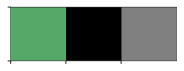

In [18]:
pal = {"control": sns.color_palette()[2], "experimental": "black", "scramble": "gray"}
sns.palplot(pal.values())

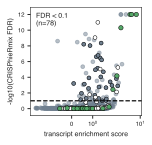

In [19]:
fig = plt.figure(figsize=(2,2))

ax = plt.gca()
ax.scatter(exp["l2fc"], exp["neg_log_FDR"], color="slategray", s=15, alpha=0.5)
ax.scatter(nopromoverlap["l2fc"], nopromoverlap["neg_log_FDR"], color="slategray", edgecolors="black",
           linewidths=0.5, s=15, alpha=1)
ax.scatter(mrna["l2fc"], mrna["neg_log_FDR"], color="white", s=15, alpha=1, edgecolors="black", linewidths=0.5)
ax.scatter(ctrl["l2fc"], ctrl["neg_log_FDR"], color=pal["control"], s=20, alpha=1, edgecolors="black",
           linewidths=0.5)
ax.scatter(scr["l2fc"], scr["neg_log_FDR"], color="gray", s=15, alpha=0.5)
ax.axhline(y=1, linestyle="dashed", color="black")
ax.set_xlabel("transcript enrichment score")
ax.set_ylabel("-log10(CRISPhieRmix FDR)")
ax.set_xscale('symlog')

# annotate #s
n_sig = len(sig)
n_not_sig = len(not_sig)
ax.text(0.05, 0.95, "FDR < 0.1\n(n=%s)" % (n_sig), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)

fig.savefig("Fig3E.pdf", dpi="figure", bbox_inches="tight")

In [20]:
crisphie[crisphie["transcript_name"].str.contains("FOXD3")]

,groups,FDR,transcript_name,group_id,ctrl_status,transcript_biotype_status,n_sgRNA,l2fc,neg_log_FDR
3380,FOXD3-001;;;NC_000001.11:+:63323041;;;mRNA;;;p...,0.961804,FOXD3-001,NC_000001.11:+:63323041,mRNA,protein_coding,4,0.340593,0.016913
3381,FOXD3-AS1-001;;;NC_000001.11:-:63324481;;;expe...,0.960758,FOXD3-AS1-001,NC_000001.11:-:63324481,experimental,transcript_overlap,6,1.125256,0.017386
3382,FOXD3-AS1-004;;;NC_000001.11:-:63323741;;;expe...,0.021872,FOXD3-AS1-004,NC_000001.11:-:63323741,experimental,promoter_overlap,5,0.910762,1.660117
3383,FOXD3-AS1-005;;;NC_000001.11:-:63321631;;;expe...,0.590125,FOXD3-AS1-005,NC_000001.11:-:63321631,experimental,intergenic,3,0.438009,0.229056


In [21]:
crisphie[crisphie["transcript_name"].str.contains("DIGIT")]

,groups,FDR,transcript_name,group_id,ctrl_status,transcript_biotype_status,n_sgRNA,l2fc,neg_log_FDR
3211,DIGIT;;;NC_000014.9:+:94770641;;;experimental;...,0.076334,DIGIT,NC_000014.9:+:94770641,experimental,promoter_overlap,4,1.976261,1.117281


## 9. write final file(s)

In [22]:
def is_hit(row):
    if row["FDR"] < 0.1:
        return "hit"
    else:
        return "no hit"
    
crisphie["hit_status"] = crisphie.apply(is_hit, axis=1)

In [23]:
supp = crisphie[["group_id", "transcript_name", "ctrl_status", "transcript_biotype_status", "FDR", "l2fc", 
                 "hit_status", "n_sgRNA"]]
supp.columns = ["group_id", "transcript_name", "ctrl_status", "transcript_biotype_status", "CRISPhieRmix_FDR", 
                "effect_size", "hit_status", "n_sgRNA"]
supp = supp.sort_values(by="CRISPhieRmix_FDR")
print(len(supp))
supp.head()

9771


,group_id,transcript_name,ctrl_status,transcript_biotype_status,CRISPhieRmix_FDR,effect_size,hit_status,n_sgRNA
9414,NC_000008.11:+:54457934,SOX17-001,control,protein_coding,0.000000e+00,7.864574,hit,7
3278,NC_000003.12:-:27722707,EOMES-004,control,protein_coding,0.000000e+00,5.932002,hit,6
3277,NC_000003.12:-:27722322,EOMES-001,control,protein_coding,0.000000e+00,5.397301,hit,6
676,NC_000023.11:-:11111137,"[RP11-120D5.1-004, RP11-120D5.1-005]",experimental,promoter_overlap,0.000000e+00,4.211808,hit,7
1911,NC_000003.12:-:38454682,ACVR2B-AS1-001,experimental,promoter_overlap,1.265654e-15,3.110333,hit,10


In [24]:
supp.hit_status.value_counts()

no hit    9693
hit         78
Name: hit_status, dtype: int64

In [25]:
supp.sort_values(by="CRISPhieRmix_FDR", ascending=True).head(10)

,group_id,transcript_name,ctrl_status,transcript_biotype_status,CRISPhieRmix_FDR,effect_size,hit_status,n_sgRNA
9414,NC_000008.11:+:54457934,SOX17-001,control,protein_coding,0.000000e+00,7.864574,hit,7
3278,NC_000003.12:-:27722707,EOMES-004,control,protein_coding,0.000000e+00,5.932002,hit,6
3277,NC_000003.12:-:27722322,EOMES-001,control,protein_coding,0.000000e+00,5.397301,hit,6
676,NC_000023.11:-:11111137,"[RP11-120D5.1-004, RP11-120D5.1-005]",experimental,promoter_overlap,0.000000e+00,4.211808,hit,7
1911,NC_000003.12:-:38454682,ACVR2B-AS1-001,experimental,promoter_overlap,1.265654e-15,3.110333,hit,10
5204,NC_000011.10:+:90223166,RP11-121L10.2-001,experimental,promoter_overlap,4.033810e-15,3.070032,hit,8
9358,NC_000019.10:+:11060127,SMARCA4-014,mRNA,protein_coding,9.154550e-12,1.243264,hit,6
3377,NC_000020.11:-:22584571,FOXA2-002,control,protein_coding,4.842431e-11,3.093366,hit,9
8978,NC_000020.11:+:37095770,RP4-621N11.2-001,experimental,promoter_overlap,3.120178e-10,0.657246,hit,5
9464,NC_000005.10:-:173329499,STC2-001,mRNA,protein_coding,8.773907e-10,1.111405,hit,6


In [26]:
f = "../../../data/02__screen/02__enrichment_data/SuppTable_S3.CRISPhieRmix_results.txt"
supp.to_csv(f, sep="\t", index=False)